# **Save this file as studentid1_studentid2_lab#.ipynb**
(Your student-id is the number shown on your student card.)

E.g. if you work with 3 people, the notebook should be named:
12301230_3434343_1238938934_lab1.ipynb.

**This will be parsed by a regexp, so please double check your filename.**

Before you turn this problem in, please make sure everything runs correctly. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

**Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names and email adresses below.**



In [ ]:
NAME = ""
NAME2 = ""
NAME3 = ""
EMAIL = ""
EMAIL2 = ""
EMAIL3 = ""

---

# Lab 3: Gaussian Processes and Support Vector Machines

### Machine Learning 1, September 2017

Notes on implementation:

* You should write your code and answers in this IPython Notebook: http://ipython.org/notebook.html. If you have problems, please contact your teaching assistant.
* Please write your answers right below the questions.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* Refer to last week's lab notes, i.e. http://docs.scipy.org/doc/, if you are unsure about what function to use. There are different correct ways to implement each problem!
* use the provided test boxes to check if your answers are correct

In [2]:
%pylab inline
plt.rcParams["figure.figsize"] = [20,10]

Populating the interactive namespace from numpy and matplotlib


## Part 1: Gaussian Processes

For part 1 we will be refer to Bishop sections 6.4.2 and 6.4.3. You may also want to refer to Rasmussen's Gaussian Process text which is available online at http://www.gaussianprocess.org/gpml/chapters/ and especially to the project found at https://www.automaticstatistician.com/index/ by Ghahramani for some intuition in GP.  To understand Gaussian processes, it is highly recommended understand how marginal, partitioned Gaussian distributions can be converted into conditional Gaussian distributions.  This is covered in Bishop 2.3 and summarized in Eqns 2.94-2.98.
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\ba}{\mathbf{a}}$

### Periodic Data

We will use the same data generating function that we used previously for regression.

In [4]:
def true_mean_function(x):
    return np.cos(2*pi*(x+1))

def add_noise(y, sigma):
    return y + sigma*np.random.randn(len(y))

def generate_t(x, sigma):
    return add_noise(true_mean_function(x), sigma)


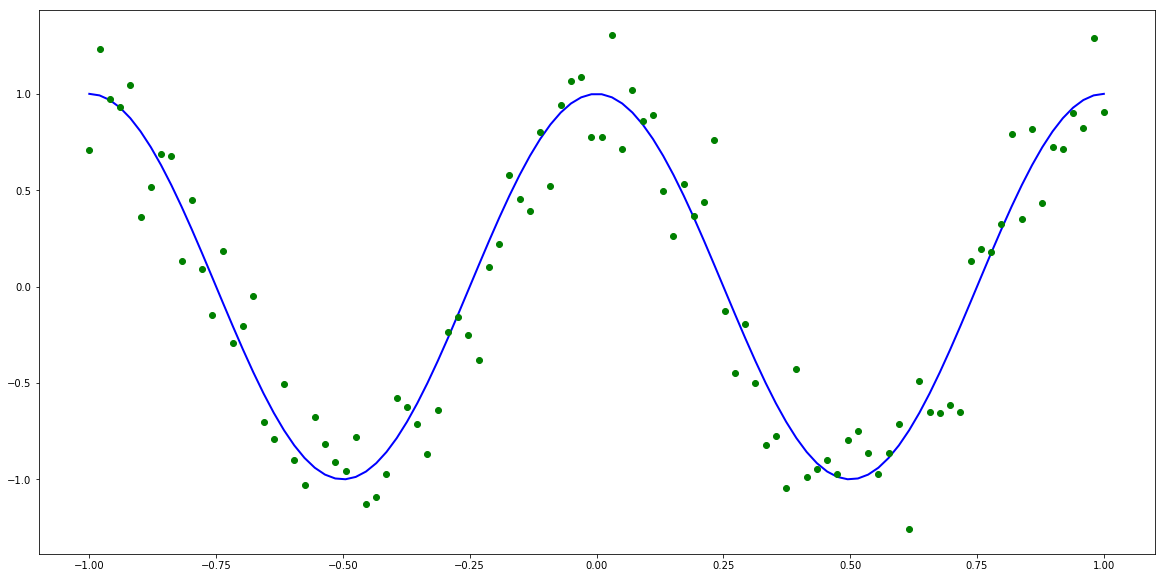

In [5]:
sigma = 0.2
beta  = 1.0 / pow(sigma, 2)
N_test = 100

x_test = np.linspace(-1, 1, N_test) 
mu_test = np.zeros(N_test)
y_test = true_mean_function(x_test)
t_test = add_noise(y_test, sigma)

plt.plot( x_test, y_test, 'b-', lw=2)
plt.plot( x_test, t_test, 'go')
plt.show()

### 1. Sampling from the Gaussian process prior (30 points)
We will implement Gaussian process regression using the kernel function in Bishop Eqn. 6.63.  

#### 1.1 k_n_m( xn, xm, thetas ) (5 points)
To start, implement function `k_n_m(xn, xm, thetas)` that takes scalars $x_n$ and $x_m$, and a vector of $4$ thetas, and computes the kernel function Bishop Eqn. 6.63 (10 points).  NB: usually the kernel function will take $D$ by $1$ vectors, but since we are using a univariate problem, this makes things easier.

In [6]:
def k_n_m(xn, xm, thetas):
    theta_0, theta_1, theta_2, theta_3 = thetas
    k = theta_0 * np.exp(-(theta_1)/(2) * (xn - xm)**2) + theta_2 + theta_3 * xn * xm 
    
    return k

#### 1.2 computeK( X1, X2, thetas ) (10 points)
Eqn 6.60 is the marginal distribution of mean output of $N$ data vectors: $p(\mathbf{y}) = \mathcal{N}(0, \mathbf{K})$.  Notice that the expected mean function is $0$ at all locations, and that the covariance is a $N$ by $N$ kernel matrix $\mathbf{K}$.  Write a function `computeK(x1, x2, thetas)`
that computes the kernel matrix. Use k_n_m as part of an inner loop (of course, there are more efficient ways of computing the kernel function making better use of vectorization, but that is not necessary) (5 points).  

In [7]:
def computeK(x1, x2, thetas):
    # YOUR CODE HERE
    K = np.zeros(shape=(len(x1), len(x2)))
    for i in range(len(x1)):
        for j in range(len(x2)):
            K[i][j] = k_n_m(x1[i], x2[j], thetas)
    
    return K

In [8]:
### Test your function
x1 = [0, 1, 2]
x2 = [1, 2, 3, 4]
thetas = [1, 2, 3, 4]
K = computeK(x1, x2, thetas)

assert K.shape == (len(x1), len(x2)), "the shape of K is incorrect"


#### 1.3 Plot function samples (15 points)
Now sample mean functions at the x_test locations for the theta values in Bishop Figure 6.5, make a figure with a 2 by 3 subplot and make sure the title reflects the theta values (make sure everything is legible).  In other words, sample $\by_i \sim \mathcal{N}(0, \mathbf{K}_{\theta})$.  Make use of numpy.random.multivariate_normal().  On your plots include the expected value of $\by$ with a dashed line and fill_between 2 standard deviations of the uncertainty due to $\mathbf{K}$ (the diagonal of $\mathbf{K}$ is the variance of the model uncertainty) (15 points).

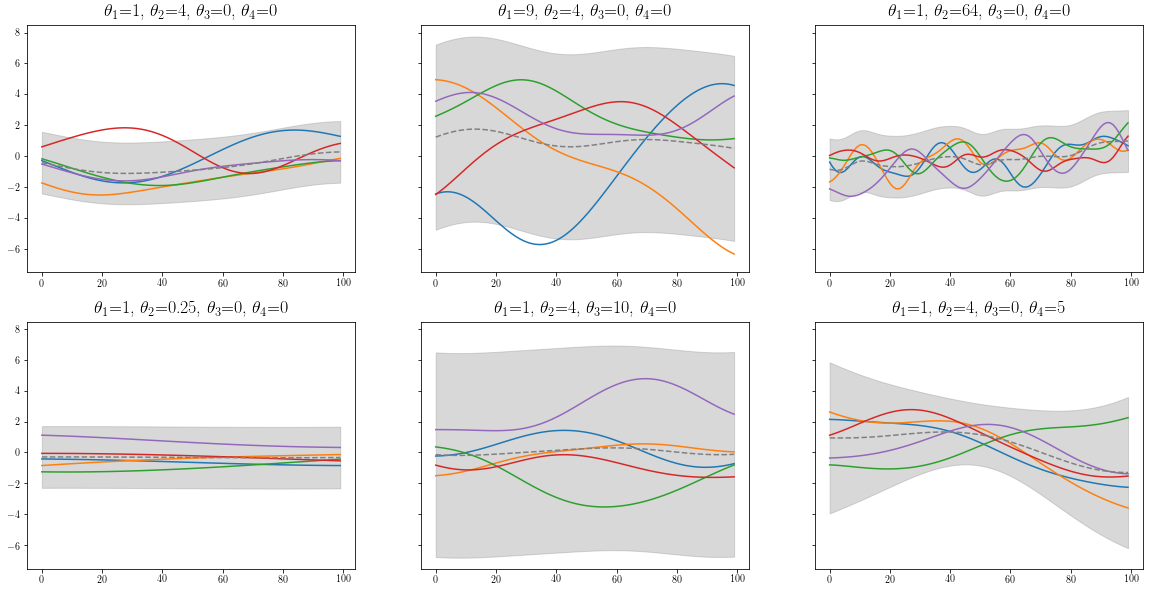

In [35]:
theta_combinations = [
    [1, 4, 0, 0],
    [9, 4, 0, 0],
    [1, 64, 0, 0],
    [1, 0.25, 0, 0],
    [1, 4, 10, 0],
    [1, 4, 0, 5]
]
K = computeK(x_test, x_test, thetas)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fig, axes = plt.subplots(2, 3, sharey="all")
n = 5  # Number of sampled functions
x = range(len(x_test))

for thetas, ax in zip(theta_combinations, axes.flatten()):
    K = computeK(x_test, x_test, thetas)
    ys = numpy.random.multivariate_normal([0] * K.shape[0], numpy.array(K), size=n)
    
    # Plot sampled functions
    for y in ys:
        ax.plot(x, y)
        
    # Plot mean function
    y_mean = ys.sum(axis=0) / len(ys)
    ax.plot(x, y_mean, linestyle="--", color="grey")
    
    # Plot uncertainty
    std_dev = numpy.sqrt(K.diagonal())
    ax.fill_between(x, y_mean - 2 * std_dev, y_mean + 2 * std_dev, alpha=0.3, color='grey')
    
    # Title
    ax.set_title(r"$\theta_1$={}, $\theta_2$={}, $\theta_3$={}, $\theta_4$={}".format(*thetas), size=18)
    

### 2. Predictive distribution (35 points)
So far we have sampled mean functions from the prior.  We can draw actual data $\bt$ two ways.  The first way is generatively, by first sampling $\by | \mathbf{K}$, then sampling $\bt | \by, \beta$ (Eqns 6.60 followed by 6.59).  The second way is to integrate over $\by$ (the mean draw) and directly sample $\bt | \mathbf{K}, \beta$ using Eqn 6.61.    This is the generative process for $\bt$.  Note that we have not specified a distribution over inputs $\bx$;  this is because Gaussian processes are conditional models.  Because of this we are free to generate locations $\bx$ when playing around with the GP; obviously a dataset will give us input-output pairs.

Once we have data, we are interested in the predictive distribution (note: the prior is the predictive distribution when there is no data).  Consider the joint distribution for $N+1$ targets, given by Eqn 6.64.  Its covariance matrix is composed of block components $C_N$, $\mathbf{k}$, and $c$.  The covariance matrix $C_N$ for $\bt_N$ is $C_N = \mathbf{K}_N + \beta^{-1}\mathbf{I}_N$.  We have just made explicit the size $N$ of the matrix; $N$ is the number of training points.  The kernel vector $\mathbf{k}$ is a $N$ by $1$ vector of kernel function evaluations between the training input data and the test input vector.  The scalar $c$ is a kernel evaluation at the test input.

#### 2.1 gp_predictive_distribution(...) (10 points)
Write a function `gp_predictive_distribution(x_train, t_train, x_test, theta, beta, C=None)` that computes  Eqns 6.66 and 6.67, except allow for an arbitrary number of test points (not just one) and now the kernel matrix is for training data.  By having C as an optional parameter, we can avoid computing it more than once (for this problem it is unimportant, but for real problems this is an issue).  The function should compute $\mathbf{C}$, $\mathbf{k}$, and return the mean, variance and $\mathbf{C}$.  Do not forget: the computeK function computes $\mathbf{K}$, not $\mathbf{C}$! (10 points)

In [47]:
from numpy.linalg import inv

def gp_predictive_distribution(x_train, t_train, x_test, theta, beta, C=None):
    if C is None:
        K = computeK(x_train, x_train, theta)
        C = K + numpy.identity(len(x_train)) * 1/beta
       
    
    c = computeK(x_test, x_test, theta)
    k = computeK(x_train, x_test, theta)
    mean_test = numpy.dot(numpy.dot(k.T, inv(C)), t_train)
    var_test = c - np.dot(np.dot(k.T, inv(C)), k)
    
    return mean_test, var_test, C

In [48]:
### Test your function
N = 2
train_x = np.linspace(-1, 1, N)
train_t = 2*train_x
test_N = 3
test_x = np.linspace(-1, 1, test_N) 
theta = [1, 2, 3, 4]
beta = 25
test_mean, test_var, C = gp_predictive_distribution(train_x, train_t, test_x, theta, beta, C=None)

assert test_mean.shape == (test_N,), "the shape of mean is incorrect"
assert test_var.shape == (test_N, test_N), "the shape of var is incorrect"
assert C.shape == (N, N), "the shape of C is incorrect"

C_in = np.array([[0.804, -0.098168436], [-0.098168436, 0.804]])
_, _, C_out = gp_predictive_distribution(train_x, train_t, test_x, theta, beta, C=C_in)

assert np.allclose(C_in, C_out), "C is not reused!"


#### 2.2 gp_log_likelihood(...) (10 points)
To learn the hyperparameters, we would need to compute the log-likelihood of the of the training data.  Implicitly, this is conditioned on the value setting for $\mathbf{\theta}$.  Write a function `gp_log_likelihood(x_train, t_train, theta, C=None, invC=None, beta=None)`, where C and invC can be stored and reused. It should return the log-likelihood, `C` and `invC`  (10 points)

In [49]:
from numpy.linalg import inv
from numpy.linalg import det

def gp_log_likelihood(x_train, t_train, theta, beta, C=None, invC=None):
    if C is None:
        K = computeK(x_train, x_train, theta)
        C = K + numpy.identity(len(x_train)) * 1/beta
        
    if invC is None:
        invC = inv(C)
        
    N = len(x_train)
    lp = -(1/2) * numpy.log(det(C)) - (1/2) * np.dot(np.dot(t_train.T, invC), t_train) - (N/2) * log(2* numpy.pi)
    
    return lp, C, invC

In [50]:
### Test your function
N = 2
train_x = np.linspace(-1, 1, N)
train_t = 2 * train_x
theta = [1, 2, 3, 4]
beta = 25
lp, C, invC = gp_log_likelihood(train_x, train_t, theta, beta, C=None, invC=None)
    
assert lp < 0, "the log-likelihood should smaller than 0"
assert C.shape == (N, N), "the shape of var is incorrect"
assert invC.shape == (N, N), "the shape of C is incorrect"

C_in = np.array([[0.804, -0.098168436], [-0.098168436, 0.804]])
_, C_out, _ = gp_log_likelihood(train_x, train_t, theta, beta, C=C_in, invC=None)

assert np.allclose(C_in, C_out), "C is not reused!"

invC_in = np.array([[1.26260453, 0.15416407], [0.15416407, 1.26260453]])
_, _, invC_out = gp_log_likelihood(train_x, train_t, theta, beta, C=None, invC=invC_in)

assert np.allclose(invC_in, invC_out), "invC is not reused!"


#### 2.3 Plotting (10 points)
Repeat the 6 plots above, but this time conditioned on the training points.  Use the periodic data generator to create 2 training points where x is sampled uniformly between $-1$ and $1$.  For these plots, feel free to use the provided function "gp_plot".  Make sure you put the parameters in the title and this time also the log-likelihood. Try to understand the two types of uncertainty!  If you do not use `gp_plot(...)`, please add a fill between for the model and target noise. (10 points)

In [51]:
def gp_plot( x_test, y_test, mean_test, var_test, x_train, t_train, theta, beta ):
    # x_test: 
    # y_test:    the true function at x_test
    # mean_test: predictive mean at x_test
    # var_test:  predictive covariance at x_test 
    # t_train:   the training values
    # theta:     the kernel parameters
    # beta:      the precision (known)
    
    # the reason for the manipulation is to allow plots separating model and data stddevs.
    std_total = np.sqrt(np.diag(var_test))       # includes all uncertainty, model and target noise 
    std_model = np.sqrt(std_total**2 - 1.0/beta) # remove data noise to get model uncertainty in stddev
    std_combo = std_model + np.sqrt(1.0/beta)    # add stddev (note: not the same as full)
    
    plt.plot(x_test, y_test, 'b', lw=3)
    plt.plot(x_test, mean_test, 'k--', lw=2)
    plt.fill_between(x_test, mean_test+2*std_combo,mean_test-2*std_combo, color='k', alpha=0.25)
    plt.fill_between(x_test, mean_test+2*std_model,mean_test-2*std_model, color='r', alpha=0.25)
    plt.plot(x_train, t_train, 'ro', ms=10)
    

/Users/dennisulmer/miniconda3/envs/ml1labs/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


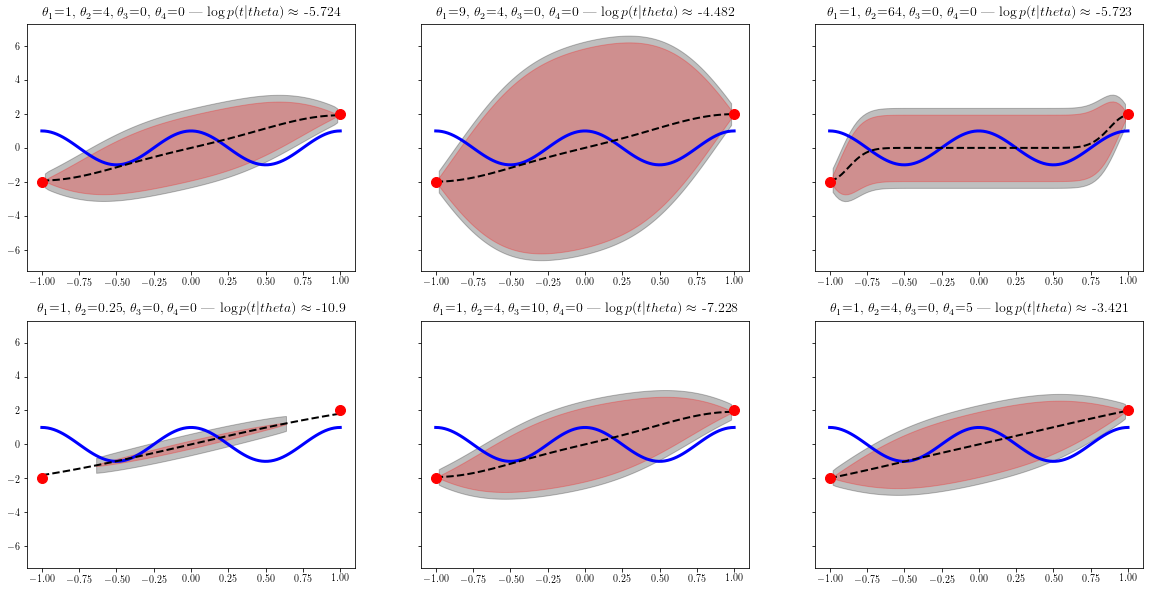

In [69]:
def adjusted_gp_plot( x_test, y_test, mean_test, var_test, x_train, t_train, theta, beta, ax, lp):
    # x_test: 
    # y_test:    the true function at x_test
    # mean_test: predictive mean at x_test
    # var_test:  predictive covariance at x_test 
    # t_train:   the training values
    # theta:     the kernel parameters
    # beta:      the precision (known)
    
    # the reason for the manipulation is to allow plots separating model and data stddevs.
    std_total = np.sqrt(np.diag(var_test))       # includes all uncertainty, model and target noise 
    std_model = np.sqrt(std_total**2 - 1.0/beta) # remove data noise to get model uncertainty in stddev
    std_combo = std_model + np.sqrt(1.0/beta)    # add stddev (note: not the same as full)
    
    ax.plot(x_test, y_test, 'b', lw=3)
    ax.plot(x_test, mean_test, 'k--', lw=2)
    ax.fill_between(x_test, mean_test+2*std_combo,mean_test-2*std_combo, color='k', alpha=0.25)
    ax.fill_between(x_test, mean_test+2*std_model,mean_test-2*std_model, color='r', alpha=0.25)
    ax.set_title(r"$\theta_1$={}, $\theta_2$={}, $\theta_3$={}, $\theta_4$={} | $\log p(t|theta) \approx$ {lp:.4}".format(*thetas, lp=lp), size=14)
    ax.plot(x_train, t_train, 'ro', ms=10)
    

N = 2
beta = 25
x_train = np.linspace(-1, 1, N)
t_train = 2 * x_train
x_test = np.linspace(-1, 1, N_test) 
y_test = true_mean_function(x_test)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

theta_combinations = [
    [1, 4, 0, 0],
    [9, 4, 0, 0],
    [1, 64, 0, 0],
    [1, 0.25, 0, 0],
    [1, 4, 10, 0],
    [1, 4, 0, 5]
]

fig, axes = plt.subplots(2, 3, sharey="all")

for thetas, ax in zip(theta_combinations, axes.flatten()):
    mean_test, var_test, C = gp_predictive_distribution(x_train, t_train, x_test, thetas, beta)
    #print("var_test", var_test)
    lp, C, invC = gp_log_likelihood(x_train, t_train, theta, beta, C=C)
    adjusted_gp_plot(x_test, y_test, mean_test, var_test, x_train, t_train, thetas, beta, ax, lp=lp)
    


#### 2.4 More plotting (5 points)
Repeat the 6 plots above, but this time conditioned a new set of 10 training points. (5 points)

/Users/dennisulmer/miniconda3/envs/ml1labs/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':


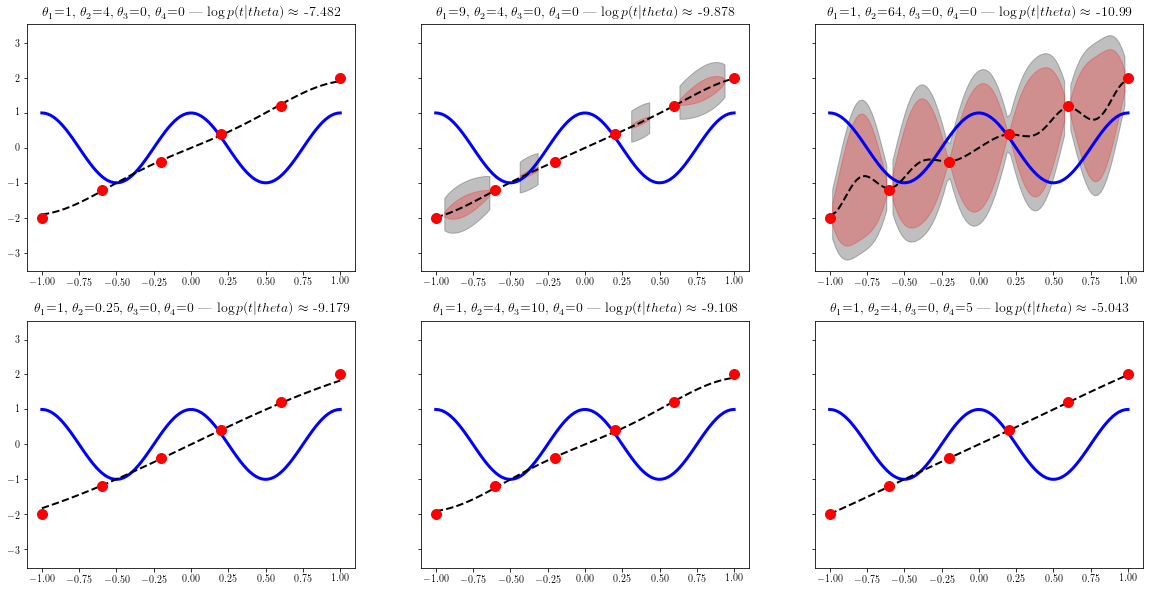

In [72]:
N = 6
beta = 25
x_train = np.linspace(-1, 1, N)
t_train = 2 * x_train
x_test = np.linspace(-1, 1, N_test) 
y_test = true_mean_function(x_test)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

theta_combinations = [
    [1, 4, 0, 0],
    [9, 4, 0, 0],
    [1, 64, 0, 0],
    [1, 0.25, 0, 0],
    [1, 4, 10, 0],
    [1, 4, 0, 5]
]

fig, axes = plt.subplots(2, 3, sharey="all")

for thetas, ax in zip(theta_combinations, axes.flatten()):
    mean_test, var_test, C = gp_predictive_distribution(x_train, t_train, x_test, thetas, beta)
    #print("var_test", var_test)
    lp, C, invC = gp_log_likelihood(x_train, t_train, theta, beta, C=C)
    adjusted_gp_plot(x_test, y_test, mean_test, var_test, x_train, t_train, thetas, beta, ax, lp=lp)
    


## Part 2: Support Vector Machines (45 points)
As seen in Part 1: Gaussian Processes, one of the significant limitations of many such algorithms is that the kernel function $k(\bx_n , \bx_m)$ must be evaluated for all possible pairs $\bx_n$ and $\bx_m$ of training points, which can be computationally infeasible during training and can lead to excessive computation times when making predictions for new data points.
In Part 2: Support Vector Machines, we shall look at kernel-based algorithms that have sparse solutions, so that predictions for new inputs depend only on the kernel function evaluated at a subset of the training data points.

### 2.1 Generating a linearly separable dataset (15 points)
a) (5 points) First of all, we are going to create our own 2D toy dataset $X$. The dataset will consists of two i.i.d. subsets $X_1$ and $X_2$, each of the subsets will be sampled from a multivariate Gaussian distribution,

\begin{align}
X_1 \sim &\mathcal{N}(\mu_1, \Sigma_1)\\
&\text{ and }\\
X_2 \sim &\mathcal{N}(\mu_2, \Sigma_2).
\end{align}

In the following, $X_1$ will have $N_1=20$ samples and a mean $\mu_1=(1,1)$. $X_2$ will have $N_2=30$ samples and a mean $\mu_2=(3,3)$.

Plot the two subsets in one figure, choose two colors to indicate which sample belongs to which subset. In addition you should choose, $\Sigma_1$ and $\Sigma_2$ in a way that the two subsets become linearly separable. (Hint: Which form has the covariance matrix for a i.i.d. dataset?)

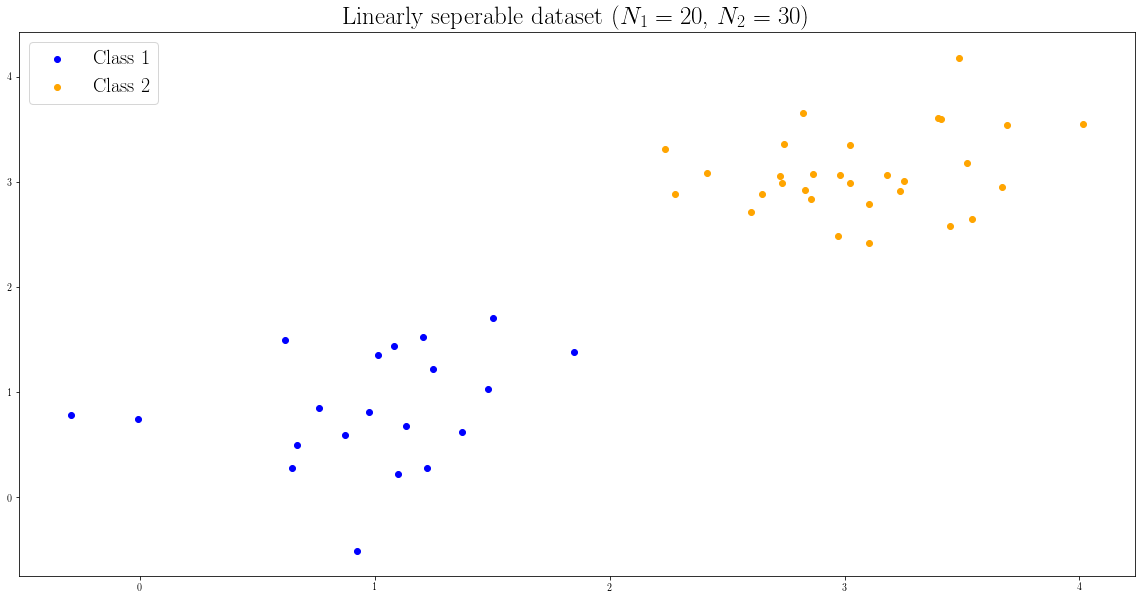

In [60]:
def gen_dataset(mean, N):
    cov = numpy.identity(len(mean)) * (0.25)
    
    raw_dataset = numpy.random.multivariate_normal(mean, cov, N)
    x = [point[0] for point in raw_dataset]
    y = [point[1] for point in raw_dataset]
    
    return x, y, raw_dataset

x_1, y_1, X_1 = gen_dataset(mean=(1, 1), N=20)
k_1 = plt.scatter(x_1, y_1, color="blue")

x_2, y_2, X_2 = gen_dataset(mean=(3, 3), N=30)
k_2 = plt.scatter(x_2, y_2, color="orange")

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.title("Linearly seperable dataset ($N_1$ = 20, $N_2$ = 30)", size=25)
plt.legend([k_1, k_2], ['Class 1', 'Class 2'], loc="upper left", fontsize=20)

b) (10 points) In the next step we will combine the two datasets X_1, X_2 and generate a vector `t` containing the labels. Write a function `create_X_and_t(X1, X2)` it should return the combined data set X and the corresponding target vector t.

In [65]:
def create_X_and_t(X1, X2):
    # YOUR CODE HERE
    X = numpy.append(X1, X2, axis=0)
    
    
    return X, t 

In [66]:
### Test your function
dim = 2
N1_test = 2
N2_test = 3
X1_test = np.arange(4).reshape((N1_test, dim))
X2_test = np.arange(6).reshape((N2_test, dim))
X_test, t_test = create_X_and_t(X1_test, X2_test)

assert X_test.shape == (N1_test + N2_test, dim), "the shape of X is incorrect"
assert t_test.shape == (N1_test + N2_test,), "the shape of t is incorrect"


[[0 1]
 [2 3]
 [0 1]
 [2 3]
 [4 5]]


NameError: name 't' is not defined

### 2.2 Finding the support vectors (15 points)
Finally we going to use a SVM to obtain the decision boundary for which the margin is maximized. We have to solve the optimization problem

\begin{align}
\arg \min_{\bw, b} \frac{1}{2} \lVert \bw \rVert^2,
\end{align}

subject to the constraints

\begin{align}
t_n(\bw^T \phi(\bx_n) + b) \geq 1, n = 1,...,N.
\end{align}

In order to solve this constrained optimization problem, we introduce Lagrange multipliers $a_n \geq 0$. We obtain the dual
representation of the maximum margin problem in which we maximize

\begin{align}
\sum_{n=1}^N a_n - \frac{1}{2}\sum_{n=1}^N\sum_{m=1}^N a_n a_m t_n t_m k(\bx_n, \bx_m),
\end{align}

with respect to a subject to the constraints

\begin{align}
a_n &\geq 0, n=1,...,N,\\
\sum_{n=1}^N a_n t_n &= 0.
\end{align}

This takes the form of a quadratic programming problem in which we optimize a quadratic function of a subject to a set of inequality constraints.



a) (5 points) In this example we will use a linear kernel $k(\bx, \bx') = \bx^T\bx'$. Write a function `computeK(X)` that computes the kernel matrix $K$ for the 2D dataset $X$.

In [ ]:
def computeK(X):
    # YOUR CODE HERE
    raise NotImplementedError()
    
    return K

In [ ]:
dim = 2
N_test = 3
X_test = np.arange(6).reshape((N_test, dim))
K_test = computeK(X_test)

assert K_test.shape == (N_test, N_test)


Next, we will rewrite the dual representation so that we can make use of computationally efficient vector-matrix multiplication. The objective becomes

\begin{align}
\min_{\ba} \frac{1}{2} \ba^T K' \ba - 1^T\ba,
\end{align}

subject to the constraints

\begin{align}
a_n &\geq 0, n=1,...,N,\\
\bt^T\ba &= 0.
\end{align}

Where
\begin{align}
K'_{nm} = t_n t_m k(\bx_n, \bx_m),
\end{align}
and in the special case of a linear kernel function,
\begin{align}
K'_{nm} = t_n t_m k(\bx_n, \bx_m) = k(t_n \bx_n, t_m \bx_m).
\end{align}

To solve the quadratic programming problem we will use a python module called cvxopt. You first have to install the module in your virtual environment (you have to activate it first), using the following command:

`conda install -c conda-forge cvxopt`

The quadratic programming solver can be called as

`cvxopt.solvers.qp(P, q[, G, h[, A, b[, solver[, initvals]]]])`

This solves the following problem,

\begin{align}
\min_{\bx} \frac{1}{2} \bx^T P \bx + q^T\bx,
\end{align}

subject to the constraints,

\begin{align}
G\bx &\leq h,\\
A\bx &= b.
\end{align}

All we need to do is to map our formulation to the cvxopt interface.

b) (10 points) Write a function `compute_multipliers(X, t)` that solves the quadratic programming problem using the cvxopt module and returns the lagrangian multiplier for every sample in the dataset. 

In [ ]:
import cvxopt

def compute_multipliers(X, t):
    # YOUR CODE HERE
    raise NotImplementedError()
    
    P = cvxopt.matrix(K)
    sol = cvxopt.solvers.qp(P, q, G, h, A, b)
    a = np.array(sol['x'])
    return a

In [ ]:
### Test your function
dim = 2
N_test = 3
X_test = np.arange(6).reshape((N_test, dim))
t_test = np.array([-1., 1., 1.])
a_test = compute_multipliers(X_test, t_test)

assert a_test.shape == (N_test, 1)


### 2.3 Plot support vectors (5 points)
Now that we have obtained the lagrangian multipliers $\ba$, we use them to find our support vectors. Repeat the plot from 2.1, this time use a third color to indicate which samples are the support vectors.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()


### 2.4 Plot the decision boundary (10 Points)
The decision boundary is fully specified by a (usually very small) subset of training samples, the support vectors. Make use of

\begin{align}
\bw &= \sum_{n=1}^N a_n t_n \mathbf{\phi}(\bx_n)\\
b &= \frac{1}{N_S}\sum_{n \in S} (t_n - \sum_{m \in S} a_m t_m k(\bx_n, \bx_m)),
\end{align}

where $S$ denotes the set of indices of the support vectors, to calculate the slope and intercept of the decision boundary. Generate a last plot that contains the two subsets, support vectors and decision boundary.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()
